<a href="https://colab.research.google.com/github/ericburdett/cs601r-dl/blob/master/DL_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS601R - Advanced Deep Learning

## Lab 1 - Basic Classifier

### Objective

* Code a basic classifier in pytorch. Prepare a scaffold that will be used for experimentation in future labs.


### Deliverable

* For this lab, you will submit an ipython notebook via learningsuite. Your notebook must contain your classifier code, and should show various final statistics about it and its performance. You should plot your loss curve, a final confusion matrix, and you must clearly display the total parameter count of your network.

### Grading Standards

Your notebook will be graded on the following:

* 45% Successfully created resnet
* 5% Clearly display the total parameter count of your network
* 20% Plotted loss curve
* 20% Showed final confusion matrix
* 10% Tidy and legible figures, including labeled axes where appropriate

### Description

For this lab, you will implement a basic pytorch image classifier on a reasonably large dataset.

Details:

Your classifier must be a 20 layer Resnet.

The dataset is the Tiny Imagenet dataset. It has 200 classes, and 500 training images per class (for a total of 100k training images), and 10,000 testing images. (The dataset provides both labels and bounding boxes; you can ignore the boxes)

You will probably want to use Google colab to host your notebook.

For your loss curve, any reasonable visualization is acceptable.

For your confusion matrix, you should display a 200×200 image, where each pixel i,j represents the number of times an image of class i was classified as class j.

You will not be graded on any final accuracies. I think this is a pretty hard dataset, so I would not expect much better performance than 40% accuracy.

You may use any code on the internet to help you, but all submitted code must be your own work.

MAJOR HINT: we will be working with this classifier in future labs by adjusting its hyper parameters. In particular, you should make it easy to:

* Change the activation function
* Change whether or not you use BatchNorm
* Change the learning rate schedule
* Change the weight regularization
* Change the weight initialization

## Import & Create the Tiny-Imagenet Dataset

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
from PIL import Image, ImageOps
import gc
import pdb
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "Request a GPU from Runtime > Change Runtime"

## Model Implementation - 20 Layer Resnet

In [0]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, batch_norm=True, activation=nn.ReLU, init_orthogonal=False, dropout=False):
    super(ResidualBlock, self).__init__()

    self.batch_norm = batch_norm
    self.dropout = dropout

    self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
    torch.nn.init.orthogonal_(self.conv1.weight)
    self.bn1 = nn.BatchNorm2d(out_channels),
    self.act = activation()
    self.drop = nn.Dropout(p=0.2)
    self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)

    if init_orthogonal:
      torch.init.orthogonol_(self.conv1.weight)
      torch.init.orthogonol_(self.conv2.weight)

    if in_channels != out_channels:
      self.needs_shortcut = True
      self.conv_short = nn.Conv2d(in_channels, out_channels, 1, bias=False)
      self.bn_short = nn.BatchNorm2d(out_channels)

      if init_orthogonal:
        torch.init.orthogonal_(self.conv_short.weight)

      if batch_norm:
        self.shortcut = nn.Sequential(
          self.conv_short,
          self.bn_short
        )
      else:
        self.shortcut = self.conv_short

    else:
      self.needs_shortcut = False

  def forward(self, x):
    identity = x if not self.needs_shortcut else self.shortcut(x)
    out = self.conv1(x)

    if batch_norm:
      out = self.bn1(out)

    out = self.act(out)

    if self.dropout:
      out = self.drop(out)

    out = self.conv2(out)

    if batch_norm:
      out = self.bn2(out)

    out += identity
    final_activation = self.activation()

    return final_activation(out)


In [0]:
class Resnet(nn.Module):
  def __init__(self, dataset, num_classes, batch_norm=False, activation=nn.ReLU, init_orthogonal=False):
    super(Resnet, self).__init__()

    x, y = dataset[0]
    in_channels, height, width = x.size()
    cstart = 64

    layers = []
    layers.append(ResidualBlock(in_channels, cstart, batch_norm=batch_norm, activation=activation, init_orthogonal=init_orthogonal))
    for i in range(19):
      layers.append(ResidualBlock(cstart, cstart, batch_norm=batch_norm, activation=activation, init_orthogonal=init_orthogonal))
  
    self.net = nn.Sequential(*layers)
    self.fc1 = nn.Linear(cstart * height * width, num_classes)

  def forward(self, x):
    # Residual Blocks
    out = self.net(x)

    # Flatten and narrow down to the number of classes
    out = torch.flatten(out, 1)
    out = self.fc1(out)

    return out

In [0]:
# For testing purposes - To get a baseline for performance
class PytorchResnet(nn.Module):
  def __init__(self, num_classes):
    super(PytorchResnet, self).__init__()

    self.model = torchvision.models.resnet152(pretrained=True)

    fc = nn.Linear(in_features=2048, out_features=num_classes)
    fc.requires_grad=True
    self.model.fc = fc

  def forward(self, x):
    return self.model(x)

In [0]:
def train():
  NUM_EPOCHS = 3
  BATCH_SIZE = 300

  train_dataset = torchvision.datasets.CIFAR10('/content/cifar-train', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
  val_dataset = torchvision.datasets.CIFAR10('/content/cifar-val', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

  model = Resnet(train_dataset, 10) #PytorchResnet(dataset.num_classes())
  model = model.cuda()

  objective = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-4)

  train_loader = DataLoader(train_dataset,
                            batch_size=BATCH_SIZE,
                            num_workers=4,
                            shuffle=True)
  val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)
  
  train_losses = []
  train_accs = []
  val_losses = []
  val_accs = []
  
  predictions = np.array([])
  actual = np.array([])

  for epoch in range(NUM_EPOCHS):
    loop = tqdm(total=len(train_loader), position=0, leave=True)

    for batch, (x, y_truth) in enumerate(train_loader):
      gc.collect()
      x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)

      optimizer.zero_grad()
      y_hat = model(x)

      acc = torch.eq(y_hat.argmax(1), y_truth.long()).float().mean()
      loss = objective(y_hat, y_truth.long())

      loss.backward()

      train_accs.append(acc.item())
      train_losses.append(loss.item())

      loop.set_description('Train - epoch:{}, loss:{:.4f}, acc:{:.4f}, avgloss:{:.4f}, avgacc:{:.4f}'.format(epoch, loss.item(), acc.item(), np.mean(train_losses), np.mean(train_accs)))
      loop.update(1)

      optimizer.step()

    with torch.no_grad():

      val_single_loss = []
      val_single_acc = []

      model.eval()

      for _, (val_x, val_y_truth) in enumerate(val_loader):
        gc.collect()
        val_x, val_y_truth = val_x.cuda(), val_y_truth.cuda()

        val_y_hat = model(val_x)

        if epoch == (NUM_EPOCHS - 1):
          predictions = np.append(predictions, val_y_hat.argmax(1).cpu().numpy())
          actual = np.append(actual, val_y_truth.cpu().numpy())

        val_acc = torch.eq(val_y_hat.argmax(1), val_y_truth.long()).float().mean()
        val_loss = objective(val_y_hat, val_y_truth.long())

        val_single_loss.append(val_loss.item())
        val_single_acc.append(val_acc.item())

      print('\nValidation - epoch:{}, loss:{:.4f}, acc:{:.4f}'.format(epoch, np.mean(val_single_loss), np.mean(val_single_acc)))

      val_accs.append(np.mean(val_single_acc))
      val_losses.append(np.mean(val_single_loss))

  loop.close()

  return model, train_losses, train_accs, val_losses, val_accs, predictions, actual

try:
  model, train_losses, train_accs, val_losses, val_accs, predictions, actual = train()
  gc.collect()
except:
  gc.collect()
  __ITB__()

## Parameter Count

In [0]:
print("Parameter Count: ", sum(param.numel() for param in model.parameters()))

Parameter Count:  2102794


## Plot the Loss/Accuracy Curves

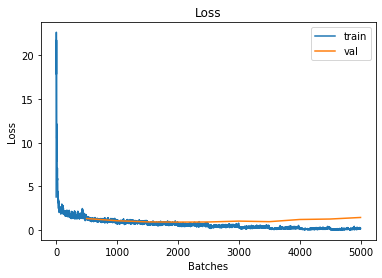

In [0]:
plt.title('Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
val_x, val_y = [x for x in range(len(train_losses) // len(val_losses), len(train_losses) + 1, len(train_losses) // len(val_losses))], val_losses
plt.plot(train_losses, label='train')
plt.plot(val_x, val_y, label='val')
plt.legend()
plt.show()

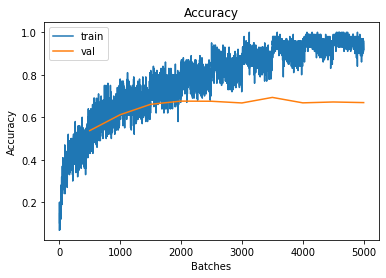

In [0]:
plt.title('Accuracy')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
val_x, val_y = [x for x in range(len(train_accs) // len(val_accs), len(train_accs) + 1, len(train_accs) // len(val_accs))], val_accs
plt.plot(train_accs, label='train')
plt.plot(val_x, val_y, label='val')
plt.legend()
plt.show()

## Plot the Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(predictions, actual)
print(matrix)

[[803  39 129  35  32  17  16  27 128  49]
 [ 13 782  10   8   3   3   2   1  41  95]
 [  7   3 327  24  16  14  14  12   6   4]
 [ 14   9  58 399  45 136  53  17   9  13]
 [ 31   7 178 105 716  55  96  99  16   9]
 [ 10   5 134 282  53 678  48  85  12   7]
 [ 18   9  84  71  54  14 744   6   6   8]
 [ 14   9  56  39  70  58  14 724   8  20]
 [ 43  10  11  13   6   5   5   2 736  14]
 [ 47 127  13  24   5  20   8  27  38 781]]


Text(123.0, 0.5, 'Actual')

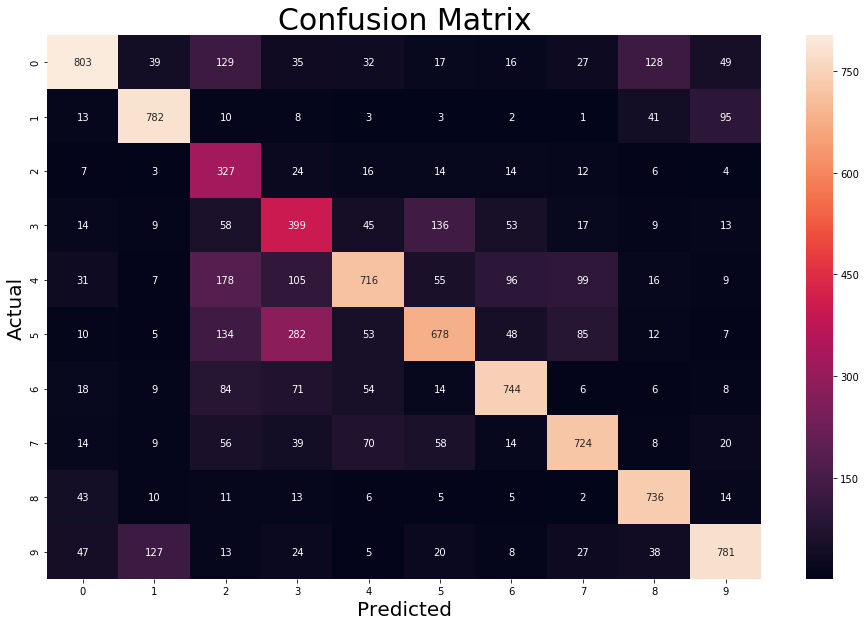

In [0]:
import seaborn as sns

plt.figure(figsize = (16, 10))
sns.heatmap(matrix, annot=True, fmt='d')

plt.title('Confusion Matrix', fontdict={'fontsize': 30})
plt.xlabel('Predicted', fontdict={'fontsize': 20})
plt.ylabel('Actual', fontdict={'fontsize': 20})

# Lab 2: Hyper Zoo

### Deliverable:
For this lab, you will submit an ipython notebook via learningsuite. Your notebook will contain two parts, as described below.

### Grading standards:
Your notebook will be graded on the following:

* 35% Part 1: Clearly displayed 10 bars (one for baseline, one for each tweak 
independently)
* 5% Part 1: Small writeup of conclusions from independent tweaks
* 25% Part 2: Clear explanation of your tweaking strategy
* 25% Part 2: Actually run your tweaking strategy and show the results
* 10% Tidy and legible figures, including labeled axes where appropriate
* 10% Extra credit - Error bars on your figure in Part 1.

### Description:
The goal of this lab is to learn how to explore the combinatorial space of possible hyperparameter settings.

Many deep learning papers present some sort of tweak on standard deep learning, and empirically illustrate that it improves performance (ideally across a wide variety of architectures and datasets). It quickly becomes hard to know: which, if any, of these tweaks are truly important - and how do they work when combined?

For this lab, you will explore various tweaks to the basic classifier you coded in lab 1. There are two parts to the lab.

### Part 1
You must clearly show the individual effect of each tweak compared to the baseline. For this part, you should present a simple bar chart (or possibly two or more, depending on your layout), clearly labeled with the baseline performance, and then the performance of each tweak relative to baseline. You may plot absolute or relative performances; whichever is clearer.

You must include a few sentences describing what you can conclude from evaluating all of these tweaks.

Note: I am not requiring error bars for this lab, because they are computationally intensive. I have made them extra credit – although if we were doing this for real, they would be absolutely required!

### Part 2
You must think about how to find the best combination of tweaks. There is no right answer to this part; I want you to think carefully about how to search the space of possible combinations, and come up with a reasonable method for settling on a final combination of tweaks. I have tried to provide enough tweaks that it should be impossible to brute-force try all possible combinations (although that is certainly a valid strategy!).

For this part, you must include in your notebook a simple writeup describing your strategy (just a paragraph or two), and then show the final performance of whatever combination you hit upon.

Note that you will not be graded on absolute performance of any run; what is important is thinking clearly through which tweaks make a difference.

### The Tweaks
Your baseline classifier must be a “vanilla” classifier, with none of the features listed below. We will systematically add them in.

You must test the following:

* Activation functions: relu (baseline), leakyrelu, selu, elu, hardshrink
* Batchnorm: off (baseline), on (use one batchnorm per residual block)
* Label smoothing: off (baseline), on
* Learning rate: constant (baseline), CLR
* Regularization: off (baseline), dropout
* Initialization: xavier/he (baseline), orthogonal

So, for part one, your bar chart should have 10 different bars.

Some of these tweaks require additional parameters. You should either leave them at their default values, or think of some reasonable way to set them.

Note: pytorch does not (AFAIK) natively implement label smoothing. In the interests of focusing on hyperparameter searching, you may verbatim copy any internet code you like to help implement label smoothing.

### Hints
Activation functions and dropout can all be found in torch.nn

Initialization functions can be found in torch.nn.init

This lab should be pretty straightforward, with the right script – you should be able to iterate over tweaks and run your classifier in a tidy loop. Ideally, you'll code it up, let it run, and come back in a few hours to find the results!

If you find yourself cutting-and-pasting, you might want to rethink your strategy.

In [0]:
def train(activation=nn.ReLU, batchnorm=False, labelsmoothing=False, clr=False, dropout=False, initialization='xavier/he'):
  NUM_EPOCHS = 5
  BATCH_SIZE = 200

  train_dataset = torchvision.datasets.CIFAR10('/content/cifar-train', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
  val_dataset = torchvision.datasets.CIFAR10('/content/cifar-val', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

  model = Resnet(train_dataset, 10) #PytorchResnet(dataset.num_classes())
  model = model.cuda()

  objective = nn.CrossEntropyLoss()

  adam = optim.Adam(model.parameters(), lr=1e-4)

  if clr:
    optimizer = torch.optim.lr_scheduler.CyclicLR(adam, 1e-4, 1e-3)
  else:
    optimizer = adam

  train_loader = DataLoader(train_dataset,
                            batch_size=BATCH_SIZE,
                            num_workers=4,
                            shuffle=True)
  val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)
  
  accuracy = 0
  
  predictions = np.array([])
  actual = np.array([])
  
  for epoch in range(NUM_EPOCHS):
    loop = tqdm(total=len(train_loader), position=0, leave=True)

    for batch, (x, y_truth) in enumerate(train_loader):
      gc.collect()
      x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)

      optimizer.zero_grad()
      y_hat = model(x)

      loss = objective(y_hat, y_truth.long())

      loss.backward()

      loop.set_description('Train - epoch:{}, loss:{:.4f}'.format(epoch, loss.item()))
      loop.update(1)

      optimizer.step()

    if epoch == (NUM_EPOCHS - 1):
      with torch.no_grad():

        val_single_acc = []

        model.eval()

        for _, (val_x, val_y_truth) in enumerate(val_loader):
          gc.collect()
          val_x, val_y_truth = val_x.cuda(), val_y_truth.cuda()

          val_y_hat = model(val_x)
          val_acc = torch.eq(val_y_hat.argmax(1), val_y_truth.long()).float().mean()

          val_single_acc.append(val_acc.item())

        accuracy = np.mean(val_single_acc)
        print('\nValidation - epoch:{}, loss:{:.4f}, acc:{:.4f}'.format(epoch, accuracy))

    loop.close()

  return accuracy